In [1]:
#Definition of library
!pip install pykdtree
!pip install kdtree
!pip install opencv-python
!pip install tensorflow
!pip install tensorflow keras


!pip install --upgrade keras tensorflow




import os
import cv2
import csv
import argparse
from scipy.io import loadmat
import csv
import math
import random
from scipy.io import loadmat
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.models import load_model
import pandas as pd
import numpy as np
import keras.backend as K
from pykdtree.kdtree import KDTree
import glob
import h5py
from scipy.io import loadmat
from tqdm import tqdm
import h5py
import scipy
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline
#from utils_gen import gen_density_map_gaussian


ImportError: cannot import name 'ImageDataGenerator' from 'keras.preprocessing.image' (C:\Users\bakiD\anaconda3\Lib\site-packages\keras\api\preprocessing\image\__init__.py)

In [2]:


def gen_density_map(img, anno_points):
   
    density_map = np.zeros_like(img, dtype=np.float64)
    h, w = density_map.shape
    kernel_size = 15 # Gaussian kernel size
    sigma = 4.0 # standard deviation

    for point in anno_points:
        # Center point coordinates of human head
        x, y = min(w-1, abs(math.floor(point[0]))), min(h-1, abs(math.floor(point[1])))
        # Upper left corner coordinates and lower right corner coordinates
        x1, y1 = x-kernel_size // 2, y-kernel_size // 2
        x2, y2 = x + kernel_size // 2 + 1, y + kernel_size // 2 + 1

        out_of_bounds = False
        dx1, dy1, dx2, dy2 = 0, 0, 0, 0 # Out of bounds offset
        # The following four ifs are used to determine whether the x and y of the two top corners are out of bounds
        if x1 <0:
            dx1 = abs(x1)
            x1 = 0
            out_of_bounds = True
        if y1 <0:
            dy1 = abs(y1)
            y1 = 0
            out_of_bounds = True
        if x2> w:
            dx2 = x2-w
            x2 = w
            out_of_bounds = True
        if y2> h:
            dy2 = y2-h
            y2 = h
            out_of_bounds = True

        if out_of_bounds:
            # If it is out of bounds, adjust the size of the Gaussian kernel
            kernel_h = kernel_size-dy1-dy2
            kernel_w = kernel_size-dx1-dx2
            # Generate a Gaussian kernel of size (kernel_h, kernel_w)
            H = np.multiply(cv2.getGaussianKernel(kernel_h, sigma), (cv2.getGaussianKernel(kernel_w, sigma)).T)
        else:
            # Generate a Gaussian kernel of size (15, 15)
            H = np.multiply(cv2.getGaussianKernel(kernel_size, sigma), (cv2.getGaussianKernel(kernel_size, sigma)).T)

        density_map[y1:y2, x1:x2] += H
    return density_map
class DataLoader(object):
    def __init__(self, data_path, gt_path, shuffle=False, gt_downsample=False):
        self.data_path = data_path
        self.gt_path = gt_path
        self.shuffle = shuffle
        self.gt_downsample = gt_downsample
        self.data_files = [filename for filename in os.listdir(data_path) if filename.endswith('.jpg')]
        self.num_samples = len(self.data_files)
        self.blob_list = []

        for fname in self.data_files:
            img = cv2.imread(os.path.join(self.data_path, fname), 0)
            img = img.astype(np.float32, copy=False)
            ht, wd = img.shape
            ht_1 = int((ht / 4) * 4)
            wd_1 = int((wd / 4) * 4)
            img = cv2.resize(img, (wd_1, ht_1))
            img = img.reshape((img.shape[0], img.shape[1], 1))

            den = pd.read_csv(os.path.join(self.gt_path, os.path.splitext(fname)[0] + '.csv'), header=None).values
            den = den.astype(np.float32, copy=False)
            if self.gt_downsample:
                wd_1 = int(wd_1 / 4)
                ht_1 = int(ht_1 / 4)
            den = cv2.resize(den, (wd_1, ht_1))
            den = den * ((wd * ht) / (wd_1 * ht_1))
            den = den.reshape((den.shape[0], den.shape[1], 1))

            blob = {'data': img, 'gt': den, 'fname': fname}
            self.blob_list.append(blob)

        if self.shuffle:
            np.random.shuffle(self.blob_list)
    
    def flow(self, batch_size=32):
        loop_count = self.num_samples // batch_size
        while True:
            if self.shuffle:
                np.random.shuffle(self.blob_list)
            for i in range(loop_count):
                blobs = self.blob_list[i * batch_size: (i + 1) * batch_size]
                X_batch = np.array([blob['data'] for blob in blobs])
                Y_batch = np.array([blob['gt'] for blob in blobs])
                yield X_batch, Y_batch

    
    def get_all(self):
        X = np.array([blob['data'] for blob in self.blob_list])
        Y = np.array([blob['gt'] for blob in self.blob_list])
        return X, Y
    
    def __iter__(self):
        for blob in self.blob_list:
            yield blob

import keras.backend as K

def mae(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred), axis=-1)


def mse(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis=-1)

In [3]:
EPOCHS = 200
TRAIN_BATCH_SIZE = 4
VAL_BATCH_SIZE = 4
dataset = 'A'
MODEL_DIR = r"C:\Users\bakiD\OneDrive\Belgeler\Shangtai\Checkpoint"

TRAIN_PATH = r"C:\Users\bakiD\OneDrive\Belgeler\Shangtai\part_A\train_data\images"
TRAIN_GT_PATH = r"C:\Users\bakiD\OneDrive\Belgeler\Shangtai\part_A\train_data\ground-truth"

VAL_PATH = r"C:\Users\bakiD\OneDrive\Belgeler\Shangtai\part_A\val_data\images"
VAL_GT_PATH = r"C:\Users\bakiD\OneDrive\Belgeler\Shangtai\part_A\val_data\ground-truth"


TEST_PATH = r"C:\Users\bakiD\OneDrive\Belgeler\Shangtai\part_A\test_data\images"
TEST_GT_PATH = r"C:\Users\bakiD\OneDrive\Belgeler\Shangtai\part_A\test_data\ground-truth"

HM_GT_PATH = r"C:\Users\bakiD\OneDrive\Belgeler\Shangtai\Heat_map"

path = r"C:\Users\bakiD\OneDrive\Belgeler\Shangtai\part_A\train_data\images"
gt_path = r"C:\Users\bakiD\OneDrive\Belgeler\Shangtai\part_A\train_data\ground-truth"
gt_path_csv = r"C:\Users\bakiD\OneDrive\Belgeler\Shangtai\ground_truth_csv"

if not os.path.exists(gt_path_csv):
    os.makedirs(gt_path_csv)
#num image
num_images = 300
x=''.join((gt_path,'\GT_IMG_1', '.mat'))
print(x)

C:\Users\bakiD\OneDrive\Belgeler\Shangtai\part_A\train_data\ground-truth\GT_IMG_1.mat


In [4]:
num_val = math.ceil(num_images * 0.1)  
indices = list(range(1, num_images + 1))
random.shuffle(indices)

for idx in range(num_images):


    i = indices[idx]
    if (idx+1) % 10 == 0:
        print('Processing {}/{} files'.format(idx+1, num_images))
    
    input_img_name = ''.join((path, 'IMG_', str(i), '.jpg'))
    if os.path.isfile(input_img_name):

      im = cv2.imread(input_img_name, 0)
      
      image_info = loadmat(''.join((gt_path, 'GT_IMG_', str(i), '.mat')))['image_info']
      annPoints = image_info[0][0][0][0][0] - 1
      
      im_density = gen_density_map.gen_density_map(im, annPoints)

      h, w = im.shape
      wn2, hn2 = w / 8, h / 8  
      wn2, hn2 = int(wn2 / 8) * 8, int(hn2 / 8) * 8  
      
      xmin, xmax = wn2, w - wn2
      ymin, ymax = hn2, h - hn2
      
      for j in range(1, N + 1):
          
          x = math.floor((xmax - xmin) * random.random() + xmin)
          y = math.floor((ymax - ymin) * random.random() + ymin)
          
          x1, y1 = x - wn2, y - hn2
          x2, y2 = x + wn2, y + hn2
          
          im_sampled = im[y1:y2, x1:x2]
          im_density_sampled = im_density[y1:y2, x1:x2]

          
          img_idx = ''.join((str(i), '_', str(j)))
          path_img, path_den = (val_path_img, val_path_den) if (idx+1) < num_val else (train_path_img, train_path_den)
          cv2.imwrite(''.join([path_img, img_idx, '.jpg']), im_sampled)
          with open(''.join([path_den, img_idx, '.csv']), 'w', newline='') as fout:
              writer = csv.writer(fout)
              writer.writerows(im_density_sampled)


Processing 10/300 files
Processing 20/300 files
Processing 30/300 files
Processing 40/300 files
Processing 50/300 files
Processing 60/300 files
Processing 70/300 files
Processing 80/300 files
Processing 90/300 files
Processing 100/300 files
Processing 110/300 files
Processing 120/300 files
Processing 130/300 files
Processing 140/300 files
Processing 150/300 files
Processing 160/300 files
Processing 170/300 files
Processing 180/300 files
Processing 190/300 files
Processing 200/300 files
Processing 210/300 files
Processing 220/300 files
Processing 230/300 files
Processing 240/300 files
Processing 250/300 files
Processing 260/300 files
Processing 270/300 files
Processing 280/300 files
Processing 290/300 files
Processing 300/300 files


In [5]:
dataset = 'A'
N = 9  
dataset_name = ''.join(['shanghaitech_part_', dataset, '_patches_', str(N)])
path = ''.join(['shanghaitech/part_', dataset, '/train_data/images/'])
output_path = 'data/formatted_trainval_{}/'.format(dataset)
train_path_img = ''.join((output_path, dataset_name, '/train/'))
train_path_den = ''.join((output_path, dataset_name, '/train_den/'))
val_path_img = ''.join((output_path, dataset_name, '/val/'))
val_path_den = ''.join((output_path, dataset_name, '/val_den/'))
gt_path = ''.join(['shanghaitech/part_', dataset, '/train_data/ground_truth'])
print(gt_path)

for i in [output_path, train_path_img, train_path_den, val_path_img, val_path_den]:
    if not os.path.exists(i):
        os.makedirs(i)

shanghaitech/part_A/train_data/ground_truth


In [6]:
import numpy as np

# Sabit tohum belirleme
seed = 26
random.seed(seed)

# Dataset bilgileri
dataset = 'A'
N = 9
dataset_name = ''.join(['ShanghaiTech_part_', dataset, '_patches_', str(N)])
path = r"C:\Users\bakiD\OneDrive\Belgeler\Shangtai\part_A\train_data\images"
output_path = 'data/formatted_trainval_{}/'.format(dataset)
train_path_img = ''.join((output_path, dataset_name, '/train/'))
train_path_den = ''.join((output_path, dataset_name, '/train_den/'))
val_path_img = ''.join((output_path, dataset_name, '/val/'))
val_path_den = ''.join((output_path, dataset_name, '/val_den/'))
gt_path = r"C:\Users\bakiD\OneDrive\Belgeler\Shangtai\part_A\train_data\ground-truth"

# Output path kontrolü ve oluşturulması
for i in [output_path, train_path_img, train_path_den, val_path_img, val_path_den]:
    if not os.path.exists(i):
        os.makedirs(i)

# Dataset boyutu
num_images = 300 if dataset == 'A' else 400

# Validation set boyutu
num_val = math.ceil(num_images * 0.1)

# İndekslerin karıştırılması
indices = list(range(1, num_images + 1))
random.shuffle(indices)

# İşleme döngüsü
for idx in range(num_images):
    i = indices[idx]
    if (idx + 1) % 10 == 0:
        print('Processing {}/{} files'.format(idx + 1, num_images))

    # Giriş resim yolu
    input_img_name = os.path.join(path, 'IMG_' + str(i) + '.jpg')
    print("Input image path:", input_img_name)  # Bu satırı ekledim

    im = cv2.imread(input_img_name, 0)
    if im is None or im.size == 0:
        print("Warning: Image could not be loaded or is empty. Skipping this image.")
        continue

    # Ground-truth dosya yolu kontrolü ve yükleme
    x11 = ''.join((gt_path, '\GT_IMG_', str(i), '.mat'))
    if not os.path.exists(x11):
        print(f'File not found: {x11}')
        continue

    try:
        image_info = loadmat(x11)['image_info']
    except Exception as e:
        print(f"Error loading file: {x11}, Error: {str(e)}")
        continue

    annPoints = image_info[0][0][0][0][0] - 1

    density_map = np.zeros_like(im, dtype=np.float64)
    print(density_map.shape)

    im_density = gen_density_map(im, annPoints)

    h, w = im.shape
    wn2, hn2 = w / 8, h / 8
    wn2, hn2 = int(wn2 / 8) * 8, int(hn2 / 8) * 8
    xmin, xmax = wn2, w - wn2
    ymin, ymax = hn2, h - hn2
    for j in range(1, N + 1):
        x = math.floor((xmax - xmin) * random.random() + xmin)
        y = math.floor((ymax - ymin) * random.random() + ymin)
        x1, y1 = x - wn2, y - hn2
        x2, y2 = x + wn2, y + hn2

        im_sampled = im[y1:y2, x1:x2]
        im_density_sampled = im_density[y1:y2, x1:x2]

        img_idx = ''.join((str(i), '_', str(j)))
        path_img, path_den = (val_path_img, val_path_den) if (idx + 1) < num_val else (train_path_img, train_path_den)
        cv2.imwrite(''.join([path_img, img_idx, '.jpg']), im_sampled)
        with open(''.join([path_den, img_idx, '.csv']), 'w', newline='') as fout:
            writer = csv.writer(fout)
            writer.writerows(im_density_sampled)

         

Input image path: C:\Users\bakiD\OneDrive\Belgeler\Shangtai\part_A\train_data\images\IMG_137.jpg
(585, 1024)
Input image path: C:\Users\bakiD\OneDrive\Belgeler\Shangtai\part_A\train_data\images\IMG_115.jpg
(611, 1021)
Input image path: C:\Users\bakiD\OneDrive\Belgeler\Shangtai\part_A\train_data\images\IMG_43.jpg
(683, 1024)
Input image path: C:\Users\bakiD\OneDrive\Belgeler\Shangtai\part_A\train_data\images\IMG_144.jpg
(768, 1024)
Input image path: C:\Users\bakiD\OneDrive\Belgeler\Shangtai\part_A\train_data\images\IMG_211.jpg
(334, 1024)
Input image path: C:\Users\bakiD\OneDrive\Belgeler\Shangtai\part_A\train_data\images\IMG_266.jpg
(391, 630)
Input image path: C:\Users\bakiD\OneDrive\Belgeler\Shangtai\part_A\train_data\images\IMG_170.jpg
(480, 722)
Input image path: C:\Users\bakiD\OneDrive\Belgeler\Shangtai\part_A\train_data\images\IMG_229.jpg
(430, 620)
Input image path: C:\Users\bakiD\OneDrive\Belgeler\Shangtai\part_A\train_data\images\IMG_160.jpg
(540, 1024)
Processing 10/300 files

In [7]:

# Veri yollarını tanımla
dataset = 'A'
N = 9  
dataset_name = ''.join(['shanghaitech_part_', dataset, '_patches_', str(N)])
print(dataset_name)
data_path = './data/formatted_trainval_{}/{}'.format(dataset, dataset_name)
train_path = os.path.join(data_path, 'train')
train_gt_path = os.path.join(data_path, 'train_den')
val_path = os.path.join(data_path, 'val')
val_gt_path = os.path.join(data_path, 'val_den')

# Verileri yükleme işlemi
print('Veriler yükleniyor, lütfen bekleyin...')
train_data_gen = DataLoader(train_path, train_gt_path, shuffle=True, gt_downsample=True)

val_data_gen = DataLoader(val_path, val_gt_path, shuffle=False, gt_downsample=True)


print('Tamamlandı')



shanghaitech_part_A_patches_9
Veriler yükleniyor, lütfen bekleyin...
Tamamlandı


Text(0, 0.5, 'count people')

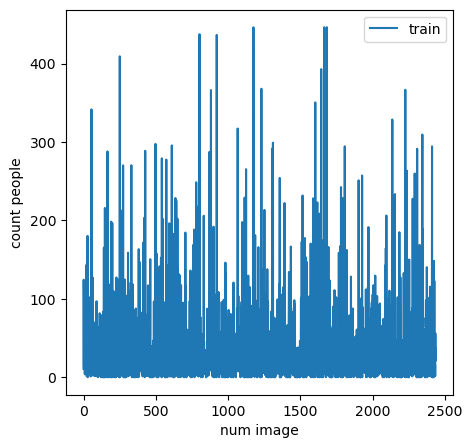

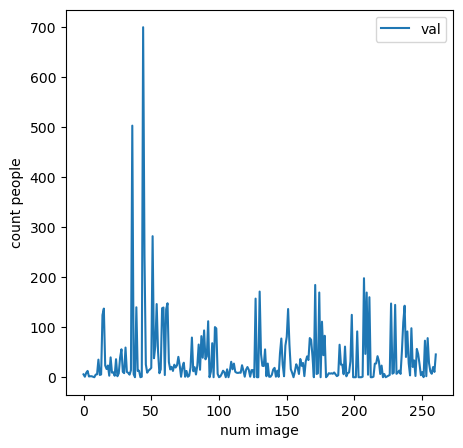

In [8]:
import matplotlib.pyplot as plt

ct_gts = []
xx=0
for blob in train_data_gen:
    xx=xx+1
    gt = blob['gt']
    gt_count = np.sum(gt)
    ct_gts.append(gt_count)

len(ct_gts)

fig,ax = plt.subplots(figsize=(5,5))
ax.plot(range(2439),ct_gts,label='train')
ax.legend()
ax.set_xlabel('num image')
ax.set_ylabel('count people')
ct_gts2 = []
xx=0
for blob2 in val_data_gen:
    xx=xx+1
    gt2 = blob2['gt']
    gt_count2 = np.sum(gt2)
    ct_gts2.append(gt_count2)
fig2,ax2 = plt.subplots(figsize=(5,5))
ax2.plot(range(261),ct_gts2,label='val')
ax2.legend()
ax2.set_xlabel('num image')
ax2.set_ylabel('count people')

In [9]:
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Concatenate


def MCNN(input_shape=None):
    inputs = Input(shape=input_shape)

    # column 1
    column_1 = Conv2D(16, (9, 9), padding='same', activation='relu')(inputs)
    column_1 = MaxPooling2D(2)(column_1)
    column_1 = (column_1)
    column_1 = Conv2D(32, (7, 7), padding='same', activation='relu')(column_1)
    column_1 = MaxPooling2D(2)(column_1)
    column_1 = Conv2D(16, (7, 7), padding='same', activation='relu')(column_1)
    column_1 = Conv2D(8, (7, 7), padding='same', activation='relu')(column_1)

    # column 2
    column_2 = Conv2D(20, (7, 7), padding='same', activation='relu')(inputs)
    column_2 = MaxPooling2D(2)(column_2)
    column_2 = (column_2)
    column_2 = Conv2D(40, (5, 5), padding='same', activation='relu')(column_2)
    column_2 = MaxPooling2D(2)(column_2)
    column_2 = Conv2D(20, (5, 5), padding='same', activation='relu')(column_2)
    column_2 = Conv2D(10, (5, 5), padding='same', activation='relu')(column_2)

    # column 3
    column_3 = Conv2D(24, (5, 5), padding='same', activation='relu')(inputs)
    column_3 = MaxPooling2D(2)(column_3)
    column_3 = (column_3)
    column_3 = Conv2D(48, (3, 3), padding='same', activation='relu')(column_3)
    column_3 = MaxPooling2D(2)(column_3)
    column_3 = Conv2D(24, (3, 3), padding='same', activation='relu')(column_3)
    column_3 = Conv2D(12, (3, 3), padding='same', activation='relu')(column_3)

    # merge feature map of 3 columns in last dimension
    merges = Concatenate(axis=-1)([column_1, column_2, column_3])
    # density map
    density_map = Conv2D(1, (1, 1), padding='same')(merges)

    model = Model(inputs=inputs, outputs=density_map)
    return model

In [10]:

#new train
input_shape = (None, None, 1)
model = MCNN(input_shape)

adam = Adam(learning_rate=1e-4)
model.compile(loss='mse', optimizer=adam, metrics=[mae, mse])


# MODEL_DIR ve dosya adını birleştirerek tam dosya yolunu oluştur
MODEL_DIR = r"C:\Users\bakiD\OneDrive\Belgeler\Shangtai\Checkpoint"
filename = 'final_model3.keras'
filepath = os.path.join(MODEL_DIR, filename)

# Modeli kaydet
model.save(filepath)

# ModelCheckpoint nesnesini oluştururken dosya uzantısını belirt
checkpointer_best_train = ModelCheckpoint(
    filepath=filepath,
    monitor='loss', verbose=1, save_best_only=True, mode='min'
)
callback_list = [checkpointer_best_train]


print('done prepaire {} ...'.format(dataset))
model.summary()

done prepaire A ...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, None, None, 1)     │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, None, None, 16)    │           1,312 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, None, None, 20)    │           1,000 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_8 (Conv2D)             │ (None, None, None, 24)    │             624 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, None, None, 16)    │               0 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, None, None, 20)    │               0 │ conv2d_4[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_4               │ (None, None, None, 24)    │               0 │ conv2d_8[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, None, None, 32)    │          25,120 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, None, None, 40)    │          20,040 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_9 (Conv2D)             │ (None, None, None, 48)    │          10,416 │ max_pooling2d_4[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, None, None, 32)    │               0 │ conv2d_1[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_3               │ (None, None, None, 40)    │               0 │ conv2d_5[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_5               │ (None, None, None, 48)    │               0 │ conv2d_9[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, None, None, 16)    │          25,104 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, None, None, 20)    │          20,02

 Total params: 127,953 (499.82 KB)

 Trainable params: 127,953 (499.82 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
from keras.models import load_model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import os

# Model yolu
model_path = os.path.join(MODEL_DIR, 'final_model3.keras')
print(model_path)
#Modeli yükle
# `mse` fonksiyonunu custom_objects parametresine tanıt
model = load_model(model_path, custom_objects={'mae': mae, 'mse': mse})


# Yeni bir optimizer ile modeli derle
adam = Adam(learning_rate=0.00000001)
model.compile(loss='mse', optimizer=adam, metrics=[mae, mse])


# Model kontrol noktası ayarla
checkpointer_best_val_loss = ModelCheckpoint(
    filepath= os.path.join(MODEL_DIR, 'final_model3.keras'),
    monitor='val_loss', verbose=1, save_best_only=True, mode='min'
)
callback_list = [checkpointer_best_val_loss]


# Model özetini yazdır
model.summary()

# 'models' klasörünü oluştur
if not os.path.exists('models'):
    os.makedirs('models')

# Modelin JSON formatında mimarisini kaydet
model_json_path = r"C:\Users\bakiD\OneDrive\Belgeler\Shangtai\Checkpoint\model.json"
with open(model_json_path, 'w') as fout:
    fout.write(model.to_json())


C:\Users\bakiD\OneDrive\Belgeler\Shangtai\Checkpoint\final_model3.keras


C:\Users\bakiD\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 54 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, None, None, 1)     │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, None, None, 16)    │           1,312 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, None, None, 20)    │           1,000 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_8 (Conv2D)             │ (None, None, None, 24)    │             624 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, None, None, 16)    │               0 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, None, None, 20)    │               0 │ conv2d_4[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_4               │ (None, None, None, 24)    │               0 │ conv2d_8[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, None, None, 32)    │          25,120 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, None, None, 40)    │          20,040 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_9 (Conv2D)             │ (None, None, None, 48)    │          10,416 │ max_pooling2d_4[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, None, None, 32)    │               0 │ conv2d_1[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_3               │ (None, None, None, 40)    │               0 │ conv2d_5[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_5               │ (None, None, None, 48)    │               0 │ conv2d_9[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, None, None, 16)    │          25,104 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, None, None, 20)    │          20,02

 Total params: 127,953 (499.82 KB)

 Trainable params: 127,953 (499.82 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
batch_size = 32
h = model.fit(train_data_gen.flow(1),
                    steps_per_epoch=train_data_gen.num_samples // 1,
                    validation_data=val_data_gen.flow(1),
                    validation_steps=val_data_gen.num_samples // 1,
                    epochs=30,
                    callbacks=callback_list,
                    verbose=1)

Epoch 1/30


AttributeError: module 'keras.backend' has no attribute 'mean'

In [ ]:
np.mean!